<a href="https://colab.research.google.com/github/rohitha077/music-recommendation/blob/main/Copy_of_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import random
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

# 1. Data Loading and Preprocessing
# Create a dummy dataset (replace with your actual data loading)
def create_dummy_data(num_users=100, num_songs=200, num_ratings=1000):
    user_ids = np.random.randint(1, num_users + 1, num_ratings)
    song_ids = np.random.randint(1, num_songs + 1, num_ratings)
    ratings = np.random.randint(1, 6, num_ratings)  # Ratings from 1 to 5
    data = {'user_id': user_ids, 'song_id': song_ids, 'rating': ratings}
    df = pd.DataFrame(data)

    # Create song metadata (for demonstration)
    song_meta = {'song_id': range(1, num_songs + 1),
                 'title': [f'Song_{i}' for i in range(1, num_songs + 1)],
                 'artist': [f'Artist_{i}' for i in range(1, num_songs + 1)],
                 'genre': [random.choice(['Pop', 'Rock', 'Electronic', 'Classical', 'Jazz']) for _ in range(num_songs)]}
    song_meta_df = pd.DataFrame(song_meta)
    return df, song_meta_df

df, song_meta_df = create_dummy_data()

# Merge song metadata
df = pd.merge(df, song_meta_df, on='song_id', how='left')

# Print info about the dataframe
print("Dataframe Info:")
df.info()

# Display the first 5 rows
print("\nFirst 5 rows of the dataframe:")
print(df.head())

# Get all unique user IDs
user_ids = df['user_id'].unique()
# Get all unique song IDs
song_ids = df['song_id'].unique()

# Create a mapping of user IDs to indices
user_id_mapping = {user_id: index for index, user_id in enumerate(user_ids)}
# Create a mapping of song IDs to indices
song_id_mapping = {song_id: index for index, song_id in enumerate(song_ids)}

# Apply the mappings to the user_id and song_id columns
df['user_index'] = df['user_id'].map(user_id_mapping)
df['song_index'] = df['song_id'].map(song_id_mapping)

# 2. Data Splitting and Scaling
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Scale the ratings to a range of 0 to 1.
scaler = MinMaxScaler()
train_df['rating'] = scaler.fit_transform(train_df[['rating']])
test_df['rating'] = scaler.transform(test_df[['rating']])

# Get the number of unique users and songs.  Use the length of the mapping.
num_users = len(user_id_mapping)
num_songs = len(song_id_mapping)

# 3. Model Building
# Define the model architecture
def create_model(num_users, num_songs, embedding_size=50):
    # Input layers for users and songs
    user_input = layers.Input(shape=(), name='user_input')
    song_input = layers.Input(shape=(), name='song_input')

    # Embedding layers for users and songs
    user_embedding = layers.Embedding(num_users, embedding_size, name='user_embedding')(user_input)
    song_embedding = layers.Embedding(num_songs, embedding_size, name='song_embedding')(song_input)

    # Flatten the embedding layers
    user_flatten = layers.Flatten()(user_embedding)
    song_flatten = layers.Flatten()(song_embedding)

    # Concatenate the flattened embeddings
    concatenated = layers.Concatenate()([user_flatten, song_flatten])

    # Dense layers for the combined features
    dense1 = layers.Dense(128, activation='relu')(concatenated)
    dense2 = layers.Dense(64, activation='relu')(dense1)
    output = layers.Dense(1, activation='sigmoid', name='output')(dense2) # Use sigmoid for scaled ratings

    # Create the model
    model = keras.Model(inputs=[user_input, song_input], outputs=output)
    return model

model = create_model(num_users, num_songs)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')  # Use MSE for the scaled ratings
# Print the model summary
print("\nModel Summary:")
model.summary()

# 4. Model Training
# Train the model
history = model.fit(
    x=[train_df['user_index'], train_df['song_index']],
    y=train_df['rating'],
    batch_size=64,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=([test_df['user_index'], test_df['song_index']], test_df['rating']),
    verbose=1
)

# 5. Recommendation Generation
def get_recommendations(user_id, model, df, song_meta_df, user_id_mapping, song_id_mapping, scaler, top_n=10):
    """
    Generates song recommendations for a given user.

    Args:
        user_id (int): The ID of the user for whom to generate recommendations.
        model: The trained recommendation model.
        df (pd.DataFrame): The original dataframe.
        song_meta_df (pd.DataFrame): DataFrame containing song metadata.
        user_id_mapping (dict): Mapping from user IDs to user indices.
        song_id_mapping (dict): Mapping from song IDs to song indices.
        scaler:  The scaler used to scale the ratings.
        top_n (int, optional): The number of top recommendations to return. Defaults to 10.

    Returns:
        pd.DataFrame: A DataFrame containing the top N recommended songs for the user,
                      with columns 'song_id', 'title', 'artist', and 'predicted_rating'.
                      Returns an empty DataFrame if the user_id is not found.
    """
    if user_id not in user_id_mapping:
        print(f"User ID {user_id} not found.")
        return pd.DataFrame()

    user_index = user_id_mapping[user_id]
    # Get all song IDs
    all_song_ids = song_meta_df['song_id'].unique()
    # Get song indices using the song_id_mapping
    all_song_indices = [song_id_mapping[song_id] for song_id in all_song_ids if song_id in song_id_mapping]

    # Create user-song pairs for all songs
    user_indices = np.array([user_index] * len(all_song_indices))
    song_indices = np.array(all_song_indices)

    # Make predictions for all songs
    predictions = model.predict([user_indices, song_indices]).flatten()

    # Inverse transform the predictions to the original scale
    predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Create a DataFrame with song IDs, and predicted ratings
    recommendation_df = pd.DataFrame({
        'song_id': [list(song_id_mapping.keys())[list(song_id_mapping.values()).index(song_index)] for song_index in all_song_indices],
        'predicted_rating': predictions_original_scale
    })

    # Merge with song metadata to get title, artist, and genre
    recommendation_df = pd.merge(recommendation_df, song_meta_df, on='song_id', how='inner')

    # Filter out songs the user has already rated.  Important!
    rated_song_ids = df[df['user_id'] == user_id]['song_id'].values
    recommendation_df = recommendation_df[~recommendation_df['song_id'].isin(rated_song_ids)]

    # Sort by predicted rating and get the top N recommendations
    top_recommendations = recommendation_df.sort_values(by='predicted_rating', ascending=False).head(top_n)
    return top_recommendations

# Get recommendations for a user (e.g., user ID 1)
user_id_to_recommend = 1
recommendations = get_recommendations(user_id_to_recommend, model, df, song_meta_df, user_id_mapping, song_id_mapping, scaler)

# Display the recommendations with styling
if not recommendations.empty:
    display(HTML(f"<h3>Top 10 Recommendations for User {user_id_to_recommend}:</h3>"))
    styled_df = recommendations.style.background_gradient(cmap='viridis').set_properties(**{'font-size': '12pt'})
    display(styled_df)
else:
    print(f"No recommendations to display for user {user_id_to_recommend}.")

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  1000 non-null   int64 
 1   song_id  1000 non-null   int64 
 2   rating   1000 non-null   int64 
 3   title    1000 non-null   object
 4   artist   1000 non-null   object
 5   genre    1000 non-null   object
dtypes: int64(3), object(3)
memory usage: 47.0+ KB

First 5 rows of the dataframe:
   user_id  song_id  rating     title      artist       genre
0       48       33       2   Song_33   Artist_33  Electronic
1       15      162       4  Song_162  Artist_162        Jazz
2       31      104       3  Song_104  Artist_104        Rock
3       26      157       5  Song_157  Artist_157  Electronic
4       48      132       4  Song_132  Artist_132        Rock

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ song_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 50)        │      5,000 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ song_embedding      │ (None, 50)        │      9,900 │ song_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ song_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,149 (141.21 KB)

 Trainable params: 36,149 (141.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.1153 - val_loss: 0.1192
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1223 - val_loss: 0.1192
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1088 - val_loss: 0.1202
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1047 - val_loss: 0.1247
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0901 - val_loss: 0.1396
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0756 - val_loss: 0.1606
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0689 - val_loss: 0.1696
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0644 - val_loss: 0.1738
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0572 - val_loss: 0.1786
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0579 - val_loss: 0.1848
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


,song_id,predicted_rating,title,artist,genre
167,170,4.638193,Song_170,Artist_170,Electronic
35,36,4.637574,Song_36,Artist_36,Classical
145,148,4.605185,Song_148,Artist_148,Classical
94,96,4.604839,Song_96,Artist_96,Electronic
95,97,4.575058,Song_97,Artist_97,Jazz
6,7,4.546762,Song_7,Artist_7,Rock
50,51,4.544945,Song_51,Artist_51,Jazz
158,161,4.522076,Song_161,Artist_161,Electronic
16,17,4.510751,Song_17,Artist_17,Electronic
118,121,4.498108,Song_121,Artist_121,Pop


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


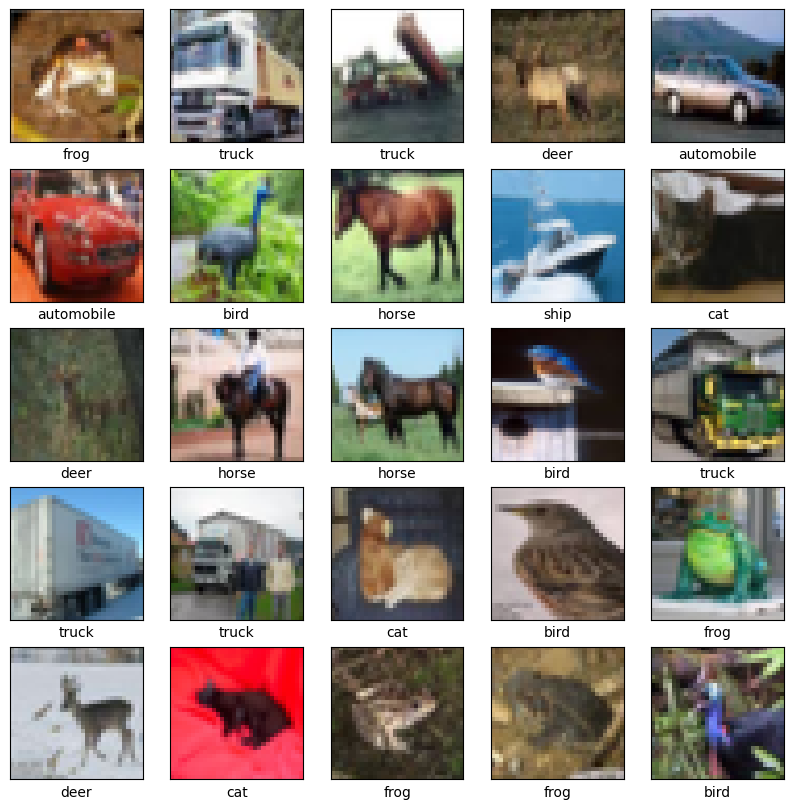

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 52ms/step - accuracy: 0.3521 - loss: 1.7476 - val_accuracy: 0.5629 - val_loss: 1.2143
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.5717 - loss: 1.1967 - val_accuracy: 0.6022 - val_loss: 1.1235
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.6405 - loss: 1.0141 - val_accuracy: 0.6562 - val_loss: 0.9685
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 49ms/step - accuracy: 0.6772 - loss: 0.9119 - val_accuracy: 0.6617 - val_loss: 0.9697
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.7122 - loss: 0.8225 - val_accuracy: 0.6892 - val_loss: 0.9003
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 49ms/step - accuracy: 0.7348 - loss: 0.7585 - val_accuracy: 0.6972 - val_loss: 0.8935
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 47ms/step - accuracy: 0.7552 - loss: 0.7044 - val_accuracy: 0.7080 - val_loss: 0.8549
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.7716 -

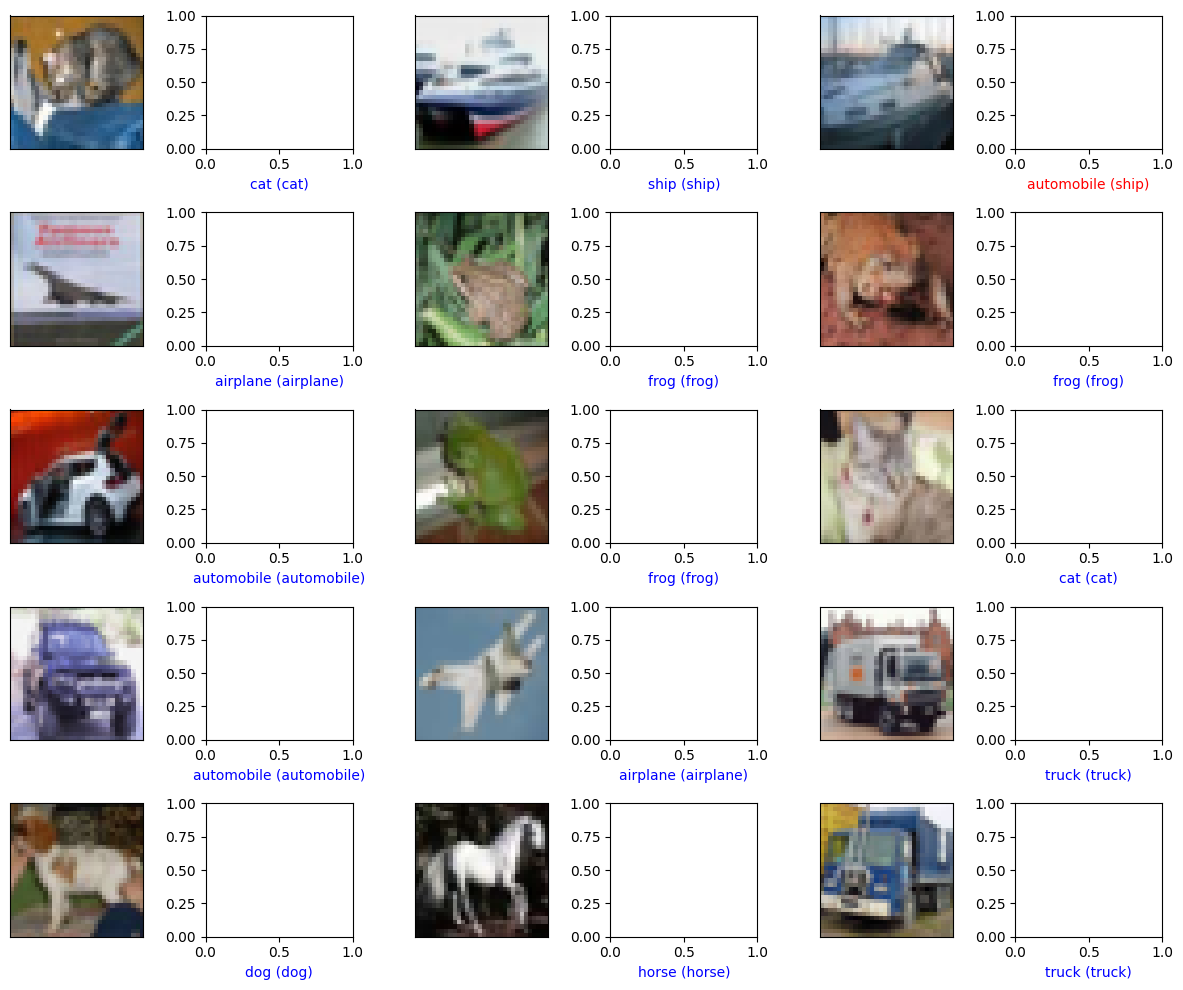

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

# Load the CIFAR-10 dataset
# The CIFAR-10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class.
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
# Dividing by 255, the maximum pixel value
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the class names.  These correspond to the labels in the dataset.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Verify the data
# Let's plot the first 25 images from the training set and display the class name below each image.
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays of length 1,
    # which is why you see the extra brackets in this indexing
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# Build the Convolutional Neural Network (CNN) model
# A common architecture for image classification tasks.
model = models.Sequential()
# Convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
# The input shape is (32, 32, 3) because CIFAR images are 32x32 pixels with 3 color channels (RGB).
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# Max pooling layer to reduce the spatial dimensions of the output
model.add(layers.MaxPooling2D((2, 2)))
# Another convolutional layer with 64 filters
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# A final convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Flatten the output to a 1D vector before feeding it to the dense layers
model.add(layers.Flatten())
# Dense (fully connected) layer with 64 units and ReLU activation
model.add(layers.Dense(64, activation='relu'))
# Output layer with 10 units (one for each class) and softmax activation for probability distribution
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
#  * optimizer: 'adam' is a good general-purpose optimizer.
#  * loss: 'categorical_crossentropy' is the standard loss function for multi-class classification.
#  * metrics: 'accuracy' is used to monitor the performance of the model during training and testing.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train the model
#  * epochs: The number of times the entire training dataset is iterated through.
#  * validation_data:  Used to evaluate the model's performance on unseen data during training.
history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

# Evaluate the model
#  Returns the loss and accuracy on the test data.
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Make predictions
#  Generates probability predictions for each class for the images in the test set.
predictions = model.predict(test_images)

# Plot the first X test images, their predicted labels, and the true labels.
# Correct predictions are blue, incorrect predictions are red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    # Get the index of the class with the highest probability.
    predicted_label = np.argmax(predictions[i])
    true_label = test_labels[i][0]
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'
    plt.xlabel("{} ({})".format(class_names[predicted_label],
                                  class_names[true_label]),
                                  color=color)
plt.tight_layout()
plt.show()